# Import Library

In [3]:
!pip install category_encoders
!pip install scikit-optimize

!pip install lightgbm
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import joblib

# Gathering Data

In [5]:
df = pd.read_csv('/content/cleaned_df.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50464 entries, 0 to 50463
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   description                50246 non-null  object 
 1   facilities                 29363 non-null  object 
 2   monthly_installment_info   50464 non-null  int64  
 3   location                   50464 non-null  object 
 4   nearby_points_of_interest  17037 non-null  object 
 5   posted_by                  50464 non-null  object 
 6   price_display              50464 non-null  object 
 7   price_numeric              50464 non-null  float64
 8   property_type              50464 non-null  object 
 9   estimated_savings          50464 non-null  float64
 10  specifications             50464 non-null  object 
 11  title                      50460 non-null  object 
 12  updatedAt                  50464 non-null  object 
 13  source_url                 50464 non-null  obj

In [7]:
df['kabupaten'].unique()

array(['jakarta selatan', 'jakarta timur', 'jakarta utara',
       'jakarta barat', 'jakarta pusat'], dtype=object)

# Pre-Processing Data

Encode

In [8]:
# Di bagian Pre-Processing Data

df['kabupaten'] = df['kabupaten'].astype(str).str.lower().str.strip()
df['s_sertifikat'] = df['s_sertifikat'].astype(str).str.lower().str.strip()

# --- Latih LabelEncoder TERPISAH untuk setiap kolom ---
le_kabupaten = LabelEncoder()
df['kabupaten_encoded'] = le_kabupaten.fit_transform(df['kabupaten'])

le_sertifikat = LabelEncoder()
df['s_sertifikat_encoded'] = le_sertifikat.fit_transform(df['s_sertifikat'])

# --- Simpan kedua encoder ---
joblib.dump(le_kabupaten, 'le_kabupaten.joblib')
print("LabelEncoder for 'kabupaten' saved as le_kabupaten.joblib")
joblib.dump(le_sertifikat, 'le_sertifikat.joblib')
print("LabelEncoder for 's_sertifikat' saved as le_sertifikat.joblib")

LabelEncoder for 'kabupaten' saved as le_kabupaten.joblib
LabelEncoder for 's_sertifikat' saved as le_sertifikat.joblib


Menghapus kolom yang tidak digunakan model machine learning

In [9]:
# Daftar kolom yang ingin dihapus untuk modelling
columns_to_drop = [
    'description',
    'monthly_installment_info',
    'location',
    'nearby_points_of_interest',
    'posted_by',
    'price_display',
    'property_type',
    'estimated_savings',
    'kabupaten', # Menghapus kolom asli setelah encoding
    's_sertifikat', # Menghapus kolom asli setelah encoding
    'specifications',
    'title',
    'source_url'
    's_daya_listrik',
    's_carport',
    's_garasi',
    's_kamar_mandi_pembantu',
    's_kamar_tidur_pembantu',
    's_kondisi_properti',
    'error',
    'updatedAt',
    'facility_lapangan_bola',
    'facilities',
    'source_url',
    's_daya_listrik'
]

# Hapus kolom dari DataFrame df
# axis=1 menunjukkan kita menghapus kolom
# errors='ignore' akan mencegah error jika salah satu kolom tidak ada
df_new = df.drop(columns=columns_to_drop, errors='ignore')

In [10]:
df_new.columns

Index(['price_numeric', 'f_akses_parkir', 'f_keamanan_24_jam', 'f_mesin_cuci',
       'f_masjid', 'f_taman', 'f_kompor', 'f_kitchen_set', 'f_laundry',
       'f_lapangan_tenis', 'f_tempat_cuci', 'f_lapangan_voli', 'f_cctv',
       'f_jogging_track', 'f_teras', 'f_taman_bermain', 'f_ac', 'f_backyard',
       'f_tempat_jemuran', 'f_kolam_renang', 'f_wastafel', 'f_one_gate_system',
       'f_tempat_gym', 'f_lapangan_bola', 'f_lapangan_bulu_tangkis',
       'f_kolam_ikan', 'f_water_heater', 'f_lapangan_basket', 'f_kulkas',
       'f_telepon', 's_jumlah_lantai', 's_kamar_mandi', 's_kamar_tidur',
       's_luas_bangunan', 's_luas_tanah', 'poi_perbelanjaan', 'poi_sekolah',
       'poi_transportasi', 'kabupaten_encoded', 's_sertifikat_encoded'],
      dtype='object')

Menghapus data yang memiliki harga diatas 4 Milliar dan dibawah 200 juta

In [11]:
# Remove rows where 'price_numeric' is above 4 billion
df_new = df_new[(df_new['price_numeric'] >= 200_000_000) & (df_new['price_numeric'] <= 4_000_000_000)]

Menhapus Data Null

In [12]:
# Menghapus baris yang memiliki nilai null di DataFrame df_new
df_new.dropna(inplace=True)

In [13]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21094 entries, 1 to 50459
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_numeric            21094 non-null  float64
 1   f_akses_parkir           21094 non-null  int64  
 2   f_keamanan_24_jam        21094 non-null  int64  
 3   f_mesin_cuci             21094 non-null  int64  
 4   f_masjid                 21094 non-null  int64  
 5   f_taman                  21094 non-null  int64  
 6   f_kompor                 21094 non-null  int64  
 7   f_kitchen_set            21094 non-null  int64  
 8   f_laundry                21094 non-null  int64  
 9   f_lapangan_tenis         21094 non-null  int64  
 10  f_tempat_cuci            21094 non-null  int64  
 11  f_lapangan_voli          21094 non-null  int64  
 12  f_cctv                   21094 non-null  int64  
 13  f_jogging_track          21094 non-null  int64  
 14  f_teras                  21

## Semua Fasilitas (df_new)

In [14]:
# Memisahkan fitur (X) dan target (Y)
X = df_new.drop('price_numeric', axis=1) # X adalah semua kolom kecuali 'price_numeric'
y = df_new['price_numeric'] # y adalah kolom 'price_numeric'

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Melakukan standarisasi pada fitur X
X_scaled = scaler.fit_transform(X)

# Konversi kembali ke DataFrame (opsional, tapi berguna untuk melihat hasil)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("\nShape of X_scaled:", X_scaled.shape)
print("\nFitur setelah Standarisasi (beberapa baris pertama):")
display(X_scaled_df.head())

# Melakukan train-test split
# test_size=0.20 artinya 20% data akan menjadi data uji, 80% data latih
# random_state=42 adalah seed untuk memastikan hasil split konsisten setiap kali kode dijalankan
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.20, random_state=42)


Shape of X: (21094, 39)
Shape of y: (21094,)

Shape of X_scaled: (21094, 39)

Fitur setelah Standarisasi (beberapa baris pertama):


,f_akses_parkir,f_keamanan_24_jam,f_mesin_cuci,f_masjid,f_taman,f_kompor,f_kitchen_set,f_laundry,f_lapangan_tenis,f_tempat_cuci,...,s_jumlah_lantai,s_kamar_mandi,s_kamar_tidur,s_luas_bangunan,s_luas_tanah,poi_perbelanjaan,poi_sekolah,poi_transportasi,kabupaten_encoded,s_sertifikat_encoded
1,1.889118,-0.879403,-0.154535,-0.407266,1.313918,-0.223317,-0.460608,-0.349572,-0.009738,3.030745,...,-0.004739,0.859599,0.275481,0.183812,0.069123,-0.442345,-0.469280,-0.581036,0.048017,0.332158
7,-0.529348,1.137135,-0.154535,-0.407266,1.313918,-0.223317,-0.460608,-0.349572,-0.009738,-0.329952,...,-0.004739,0.157229,-0.298105,-0.294524,0.239247,-0.442345,-0.469280,-0.581036,0.048017,0.332158
13,-0.529348,-0.879403,-0.154535,-0.407266,-0.761083,-0.223317,-0.460608,-0.349572,-0.009738,-0.329952,...,0.965748,0.157229,-0.298105,0.274165,-0.173911,-0.442345,-0.469280,-0.581036,0.048017,0.332158
14,1.889118,1.137135,-0.154535,2.455400,1.313918,-0.223317,-0.460608,2.860644,-0.009738,-0.329952,...,0.965748,0.859599,0.275481,0.236961,0.810377,-0.442345,-0.469280,-0.581036,0.048017,0.332158
19,-0.529348,-0.879403,-0.154535,-0.407266,-0.761083,-0.223317,-0.460608,-0.349572,-0.009738,-0.329952,...,-0.004739,0.157229,0.275481,0.003107,0.020517,-0.442345,2.130926,1.721063,0.048017,0.332158


## Fasilias Tertentu (df_new2)

In [15]:
# Daftar kolom yang ingin dipertahankan untuk df_new2
columns_to_keep_df_new2 = [
    'price_numeric', # Kolom target
    'f_one_gate_system',
    'f_kompor',
    'f_water_heater',
    'f_kulkas',
    'f_kitchen_set',
    's_jumlah_lantai',
    's_kamar_mandi',
    's_kamar_tidur',
    's_luas_bangunan',
    's_luas_tanah',
    'poi_transportasi',
    'kabupaten_encoded', # Kolom yang sudah di-encoded
    's_sertifikat_encoded', # Kolom yang sudah di-encoded
]

# Buat df_new2 baru dengan hanya menyertakan kolom yang diinginkan dari df_new
# Menggunakan .copy() untuk menghindari SettingWithCopyWarning
df_new2 = df_new[columns_to_keep_df_new2].copy()

# Tampilkan informasi DataFrame setelah pemilihan kolom untuk verifikasi
print("\nDataFrame df_new2 setelah pemilihan kolom:")
df_new2.info()

# Menampilkan beberapa baris pertama dari df_new2
display(df_new2.head())


DataFrame df_new2 setelah pemilihan kolom:
<class 'pandas.core.frame.DataFrame'>
Index: 21094 entries, 1 to 50459
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_numeric         21094 non-null  float64
 1   f_one_gate_system     21094 non-null  int64  
 2   f_kompor              21094 non-null  int64  
 3   f_water_heater        21094 non-null  int64  
 4   f_kulkas              21094 non-null  int64  
 5   f_kitchen_set         21094 non-null  int64  
 6   s_jumlah_lantai       21094 non-null  float64
 7   s_kamar_mandi         21094 non-null  float64
 8   s_kamar_tidur         21094 non-null  float64
 9   s_luas_bangunan       21094 non-null  float64
 10  s_luas_tanah          21094 non-null  float64
 11  poi_transportasi      21094 non-null  int64  
 12  kabupaten_encoded     21094 non-null  int64  
 13  s_sertifikat_encoded  21094 non-null  int64  
dtypes: float64(6), int64(8)
memory 

,price_numeric,f_one_gate_system,f_kompor,f_water_heater,f_kulkas,f_kitchen_set,s_jumlah_lantai,s_kamar_mandi,s_kamar_tidur,s_luas_bangunan,s_luas_tanah,poi_transportasi,kabupaten_encoded,s_sertifikat_encoded
1,3.150000e+09,0,0,0,0,0,2.0,4.0,4.0,190.0,128.0,0,2,8
7,2.000000e+09,1,0,0,0,0,2.0,3.0,3.0,100.0,156.0,0,2,8
13,3.200000e+09,0,0,0,0,0,3.0,3.0,3.0,207.0,88.0,0,2,8
14,3.720000e+09,1,0,0,0,0,3.0,4.0,4.0,200.0,250.0,0,2,8
19,2.700000e+09,0,0,0,0,0,2.0,3.0,4.0,156.0,120.0,1,2,8


In [16]:
# Memisahkan fitur (X) dan target (Y) untuk df_new2
X2 = df_new2.drop('price_numeric', axis=1) # X2 adalah semua kolom kecuali 'price_numeric'
y2 = df_new2['price_numeric'] # y2 adalah kolom 'price_numeric'

print("\nShape of X2:", X2.shape)
print("Shape of y2:", y2.shape)

# Inisialisasi StandardScaler
scaler2 = StandardScaler()

# Melakukan standarisasi pada fitur X2
X_scaled2 = scaler2.fit_transform(X2)

# Konversi kembali ke DataFrame (opsional)
X_scaled_df2 = pd.DataFrame(X_scaled2, columns=X2.columns, index=X2.index)

print("\nShape of X_scaled2:", X_scaled2.shape)
print("\nFitur setelah Standarisasi (df_new2, beberapa baris pertama):")
display(X_scaled_df2.head())

# Melakukan train-test split untuk data tanpa fasilitas
# test_size=0.20 artinya 20% data akan menjadi data uji, 80% data latih
# random_state=42 adalah seed untuk memastikan hasil split konsisten
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled_df2, y2, test_size=0.20, random_state=42)

print("\nShape of X_train2:", X_train2.shape)
print("Shape of X_test2:", X_test2.shape)
print("Shape of y_train2:", y_train2.shape)
print("Shape of y_test2:", y_test2.shape)


Shape of X2: (21094, 13)
Shape of y2: (21094,)

Shape of X_scaled2: (21094, 13)

Fitur setelah Standarisasi (df_new2, beberapa baris pertama):


,f_one_gate_system,f_kompor,f_water_heater,f_kulkas,f_kitchen_set,s_jumlah_lantai,s_kamar_mandi,s_kamar_tidur,s_luas_bangunan,s_luas_tanah,poi_transportasi,kabupaten_encoded,s_sertifikat_encoded
1,-0.567022,-0.223317,-0.289386,-0.184719,-0.460608,-0.004739,0.859599,0.275481,0.183812,0.069123,-0.581036,0.048017,0.332158
7,1.763601,-0.223317,-0.289386,-0.184719,-0.460608,-0.004739,0.157229,-0.298105,-0.294524,0.239247,-0.581036,0.048017,0.332158
13,-0.567022,-0.223317,-0.289386,-0.184719,-0.460608,0.965748,0.157229,-0.298105,0.274165,-0.173911,-0.581036,0.048017,0.332158
14,1.763601,-0.223317,-0.289386,-0.184719,-0.460608,0.965748,0.859599,0.275481,0.236961,0.810377,-0.581036,0.048017,0.332158
19,-0.567022,-0.223317,-0.289386,-0.184719,-0.460608,-0.004739,0.157229,0.275481,0.003107,0.020517,1.721063,0.048017,0.332158



Shape of X_train2: (16875, 13)
Shape of X_test2: (4219, 13)
Shape of y_train2: (16875,)
Shape of y_test2: (4219,)


In [17]:
a= 2

# Model

### Semua Fasilitas

Random Forest

In [28]:
# Inisialisasi model Random Forest Regressor
# n_estimators=100 adalah jumlah pohon dalam forest
# random_state=42 untuk hasil yang konsisten
model_rf = RandomForestRegressor(random_state=42, n_estimators=80)

# Melatih model menggunakan data latih
model_rf.fit(X_train, y_train)

# Melakukan prediksi pada data uji
y_pred_rf = model_rf.predict(X_test)

# # Evaluasi Model Random Forest

# Fungsi untuk menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    # Menghindari pembagian dengan nol dengan mengganti nilai 0 pada y_true dengan nilai yang sangat kecil (misalnya 1e-9)
    # Atau bisa juga dengan hanya menghitung MAPE pada baris di mana y_true bukan nol
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Hanya hitung MAPE untuk nilai y_true yang tidak nol
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Menghitung metrik evaluasi
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

# Menampilkan hasil evaluasi
print("Evaluasi Model Random Forest")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R-squared (R2): {r2_rf:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf:.2f}%")

Evaluasi Model Random Forest
Mean Absolute Error (MAE): 340591673.60
Mean Squared Error (MSE): 231428187506545056.00
Root Mean Squared Error (RMSE): 481069836.41
R-squared (R2): 0.72
Mean Absolute Percentage Error (MAPE): 16.47%


Gradient Boosting

In [19]:
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Melatih model menggunakan data latih
print("\nMelatih model Gradient Boosting...")
model_gb.fit(X_train, y_train)
print("Model Gradient Boosting selesai dilatih.")

# Melakukan prediksi pada data uji
y_pred_gb = model_gb.predict(X_test)

# # Evaluasi Model Gradient Boosting

# Menghitung metrik evaluasi
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model Gradient Boosting")
print(f"Mean Absolute Error (MAE): {mae_gb:.2f}")
print(f"Mean Squared Error (MSE): {mse_gb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.2f}")
print(f"R-squared (R2): {r2_gb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gb:.2f}%")


Melatih model Gradient Boosting...
Model Gradient Boosting selesai dilatih.

Evaluasi Model Gradient Boosting
Mean Absolute Error (MAE): 418724819.92
Mean Squared Error (MSE): 290508317696587712.00
Root Mean Squared Error (RMSE): 538988235.21
R-squared (R2): 0.65
Mean Absolute Percentage Error (MAPE): 20.61%


XGBoost

In [20]:
model_xgb = XGBRegressor(objective='reg:squarederror', # objective untuk regresi
                         n_estimators=100,
                         learning_rate=0.1,
                         max_depth=5, # Umumnya sedikit lebih dalam dari GB
                         random_state=42,
                         n_jobs=-1) # Menggunakan semua core CPU yang tersedia

model_xgb.fit(X_train, y_train) # Fit the model using the training data

# Melakukan prediksi pada data uji
y_pred_xgb = model_xgb.predict(X_test)

# # Evaluasi Model XGBoost

# Menghitung metrik evaluasi
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model XGBoost")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R-squared (R2): {r2_xgb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%")


Evaluasi Model XGBoost
Mean Absolute Error (MAE): 396971438.49
Mean Squared Error (MSE): 266992941617665280.00
Root Mean Squared Error (RMSE): 516713597.28
R-squared (R2): 0.68
Mean Absolute Percentage Error (MAPE): 19.35%


In [21]:
model_cb = CatBoostRegressor(iterations=100, # Mirip n_estimators
                             learning_rate=0.1,
                             depth=6, # Mirip max_depth
                             loss_function='RMSE', # Metrik loss
                             random_state=42,
                             verbose=0) # Set verbose=True jika ingin melihat progress

# Melatih model menggunakan data latih
print("\nMelatih model CatBoost...")
model_cb.fit(X_train, y_train)
print("Model CatBoost selesai dilatih.")

# Melakukan prediksi pada data uji
y_pred_cb = model_cb.predict(X_test)

# # Evaluasi Model CatBoost

# Menghitung metrik evaluasi
mae_cb = mean_absolute_error(y_test, y_pred_cb)
mse_cb = mean_squared_error(y_test, y_pred_cb)
rmse_cb = np.sqrt(mse_cb)
r2_cb = r2_score(y_test, y_pred_cb)
mape_cb = mean_absolute_percentage_error(y_test, y_pred_cb)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model CatBoost")
print(f"Mean Absolute Error (MAE): {mae_cb:.2f}")
print(f"Mean Squared Error (MSE): {mse_cb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_cb:.2f}")
print(f"R-squared (R2): {r2_cb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_cb:.2f}%")


Melatih model CatBoost...
Model CatBoost selesai dilatih.

Evaluasi Model CatBoost
Mean Absolute Error (MAE): 409204661.25
Mean Squared Error (MSE): 280135199769879616.00
Root Mean Squared Error (RMSE): 529277998.57
R-squared (R2): 0.66
Mean Absolute Percentage Error (MAPE): 20.04%


LightGBM

In [22]:
model_lgbm = lgb.LGBMRegressor(objective='regression',
                               metric='rmse',
                               n_estimators=100,
                               learning_rate=0.1,
                               num_leaves=31, # Default
                               random_state=42,
                               n_jobs=-1) # Menggunakan semua core CPU

# Melatih model menggunakan data latih (df_new)
model_lgbm.fit(X_train, y_train)

# Melakukan prediksi pada data uji (df_new)
y_pred_lgbm = model_lgbm.predict(X_test)

# # Evaluasi Model LightGBM (df_new)

# Menghitung metrik evaluasi
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(y_test, y_pred_lgbm)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model LightGBM (df_new)")
print(f"Mean Absolute Error (MAE): {mae_lgbm:.2f}")
print(f"Mean Squared Error (MSE): {mse_lgbm:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lgbm:.2f}")
print(f"R-squared (R2): {r2_lgbm:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lgbm:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 16875, number of used features: 33
[LightGBM] [Info] Start training from score 2383061810.145659

Evaluasi Model LightGBM (df_new)
Mean Absolute Error (MAE): 389476379.68
Mean Squared Error (MSE): 258408876860365696.00
Root Mean Squared Error (RMSE): 508339332.40
R-squared (R2): 0.69
Mean Absolute Percentage Error (MAPE): 18.97%


### Fasilias Tertentu

In [23]:
model_rf2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Melatih model menggunakan data latih dari df_new2
model_rf2.fit(X_train2, y_train2)

# Melakukan prediksi pada data uji dari df_new2
y_pred_rf2 = model_rf2.predict(X_test2)

# # Evaluasi Model Random Forest untuk df_new2

# Menghitung metrik evaluasi
mae_rf2 = mean_absolute_error(y_test2, y_pred_rf2)
mse_rf2 = mean_squared_error(y_test2, y_pred_rf2)
rmse_rf2 = np.sqrt(mse_rf2)
r2_rf2 = r2_score(y_test2, y_pred_rf2)
mape_rf2 = mean_absolute_percentage_error(y_test2, y_pred_rf2)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model Random Forest (df_new2)")
print(f"Mean Absolute Error (MAE): {mae_rf2:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf2:.2f}")
print(f"R-squared (R2): {r2_rf2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf2:.2f}%")


Evaluasi Model Random Forest (df_new2)
Mean Absolute Error (MAE): 339994351.55
Mean Squared Error (MSE): 238970969089081728.00
Root Mean Squared Error (RMSE): 488846570.09
R-squared (R2): 0.71
Mean Absolute Percentage Error (MAPE): 16.49%


Gradient Boosting

In [24]:
# Inisialisasi model Gradient Boosting Regressor
# Sesuaikan parameter seperti n_estimators, learning_rate, max_depth sesuai kebutuhan
model_gb2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Melatih model menggunakan data latih dari df_new2
model_gb2.fit(X_train2, y_train2)

# Melakukan prediksi pada data uji dari df_new2
y_pred_gb2 = model_gb2.predict(X_test2)

# # Evaluasi Model Gradient Boosting untuk df_new2

# Menghitung metrik evaluasi
mae_gb2 = mean_absolute_error(y_test2, y_pred_gb2)
mse_gb2 = mean_squared_error(y_test2, y_pred_gb2)
rmse_gb2 = np.sqrt(mse_gb2)
r2_gb2 = r2_score(y_test2, y_pred_gb2)
mape_gb2 = mean_absolute_percentage_error(y_test2, y_pred_gb2)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model Gradient Boosting (df_new2)")
print(f"Mean Absolute Error (MAE): {mae_gb2:.2f}")
print(f"Mean Squared Error (MSE): {mse_gb2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gb2:.2f}")
print(f"R-squared (R2): {r2_gb2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gb2:.2f}%")


Evaluasi Model Gradient Boosting (df_new2)
Mean Absolute Error (MAE): 421427023.73
Mean Squared Error (MSE): 293391967803029952.00
Root Mean Squared Error (RMSE): 541656688.14
R-squared (R2): 0.64
Mean Absolute Percentage Error (MAPE): 20.75%


XGBoost

In [25]:
model_xgb2 = XGBRegressor(objective='reg:squarederror',
                          n_estimators=100,
                          learning_rate=0.1,
                          max_depth=5,
                          random_state=42,
                          n_jobs=-1)

# Melatih model menggunakan data latih dari df_new2
model_xgb2.fit(X_train2, y_train2)

# Melakukan prediksi pada data uji dari df_new2
y_pred_xgb2 = model_xgb2.predict(X_test2)

# # Evaluasi Model XGBoost untuk df_new2

# Menghitung metrik evaluasi
mae_xgb2 = mean_absolute_error(y_test2, y_pred_xgb2)
mse_xgb2 = mean_squared_error(y_test2, y_pred_xgb2)
rmse_xgb2 = np.sqrt(mse_xgb2)
r2_xgb2 = r2_score(y_test2, y_pred_xgb2)
mape_xgb2 = mean_absolute_percentage_error(y_test2, y_pred_xgb2)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model XGBoost (df_new2)")
print(f"Mean Absolute Error (MAE): {mae_xgb2:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb2:.2f}")
print(f"R-squared (R2): {r2_xgb2:.2f}")



Evaluasi Model XGBoost (df_new2)
Mean Absolute Error (MAE): 405544248.31
Mean Squared Error (MSE): 277747114339317472.00
Root Mean Squared Error (RMSE): 527017186.00
R-squared (R2): 0.66


CatBoost

In [26]:
# verbose=0 untuk menghilangkan output training yang terlalu banyak
model_cb2 = CatBoostRegressor(iterations=100, # Jumlah boosting iterations (estimators)
                              learning_rate=0.1,
                              depth=6, # Kedalaman pohon
                              l2_leaf_reg=3, # Regularization
                              loss_function='RMSE', # Loss function untuk regresi
                              random_state=42,
                              verbose=0) # Mengurangi verbosity

# Melatih model menggunakan data latih dari df_new2
# Menggunakan pool jika ada data kategori, tapi di sini kita sudah encode
model_cb2.fit(X_train2, y_train2,
              eval_set=(X_test2, y_test2), # Data validasi untuk early stopping
              early_stopping_rounds=10, # Stop jika validasi tidak membaik selama 10 iterasi
              verbose=False) # Matikan verbose selama training untuk output yang lebih bersih

# Melakukan prediksi pada data uji dari df_new2
y_pred_cb2 = model_cb2.predict(X_test2)

# # Evaluasi Model CatBoost untuk df_new2

# Menghitung metrik evaluasi
mae_cb2 = mean_absolute_error(y_test2, y_pred_cb2)
mse_cb2 = mean_squared_error(y_test2, y_pred_cb2)
rmse_cb2 = np.sqrt(mse_cb2)
r2_cb2 = r2_score(y_test2, y_pred_cb2)
mape_cb2 = mean_absolute_percentage_error(y_test2, y_pred_cb2)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model CatBoost (df_new2)")
print(f"Mean Absolute Error (MAE): {mae_cb2:.2f}")
print(f"Mean Squared Error (MSE): {mse_cb2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_cb2:.2f}")
print(f"R-squared (R2): {r2_cb2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_cb2:.2f}%")


Evaluasi Model CatBoost (df_new2)
Mean Absolute Error (MAE): 417138162.66
Mean Squared Error (MSE): 288506045478334464.00
Root Mean Squared Error (RMSE): 537127587.71
R-squared (R2): 0.65
Mean Absolute Percentage Error (MAPE): 20.48%


LightGBM

In [27]:
model_lgb2 = lgb.LGBMRegressor(objective='regression',
                              metric='rmse',
                              n_estimators=100,
                              learning_rate=0.1,
                              random_state=42,
                              n_jobs=-1)

# Melatih model menggunakan data latih dari df_new2
# Menggunakan early_stopping_rounds untuk menghentikan training jika validasi tidak membaik
model_lgb2.fit(X_train2, y_train2,
               eval_set=[(X_test2, y_test2)], # Data validasi
               eval_metric='rmse', # Metrik evaluasi pada data validasi
               callbacks=[lgb.early_stopping(10, verbose=False)]) # Stop jika validasi tidak membaik selama 10 iterasi

# Melakukan prediksi pada data uji dari df_new2
y_pred_lgb2 = model_lgb2.predict(X_test2)

# # Evaluasi Model LightGBM untuk df_new2

# Menghitung metrik evaluasi
mae_lgb2 = mean_absolute_error(y_test2, y_pred_lgb2)
mse_lgb2 = mean_squared_error(y_test2, y_pred_lgb2)
rmse_lgb2 = np.sqrt(mse_lgb2)
r2_lgb2 = r2_score(y_test2, y_pred_lgb2)
mape_lgb2 = mean_absolute_percentage_error(y_test2, y_pred_lgb2)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model LightGBM (df_new2)")
print(f"Mean Absolute Error (MAE): {mae_lgb2:.2f}")
print(f"Mean Squared Error (MSE): {mse_lgb2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lgb2:.2f}")
print(f"R-squared (R2): {r2_lgb2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lgb2:.2f}%")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 16875, number of used features: 13
[LightGBM] [Info] Start training from score 2383061810.145659

Evaluasi Model LightGBM (df_new2)
Mean Absolute Error (MAE): 395831028.18
Mean Squared Error (MSE): 268234832053471520.00
Root Mean Squared Error (RMSE): 517913923.40
R-squared (R2): 0.67
Mean Absolute Percentage Error (MAPE): 19.45%


## Melakukan tuning dengan bayesian search

#### Tuning Random Forest Semua Faslitas

In [ ]:
# Definisikan ruang pencarian hyperparameter untuk Random Forest
# Sesuaikan rentang nilai berdasarkan pengetahuan domain atau percobaan awal
param_space_rf = {
    'n_estimators': Integer(1000, 2000),       # Jumlah pohon dalam forest
    'max_depth': Integer(10, 50),            # Kedalaman maksimum pohon
    'min_samples_split': Integer(2, 20),     # Jumlah sampel minimum untuk memecah node internal
    'min_samples_leaf': Integer(1, 10),      # Jumlah sampel minimum yang diperlukan di node daun
    'max_features': Real(0.5, 1.0, prior='uniform'), # Proporsi fitur yang dipertimbangkan untuk setiap split
    'bootstrap': [True, False]               # Apakah sampel bootstrap digunakan saat membangun pohon
}

# Karena skopt.BayesSearchCV mengoptimalkan fungsi tujuan yang ingin diminimalkan,
# dan metrik default seperti 'neg_mean_absolute_error' sudah diminimalkan (lebih negatif lebih baik),
# untuk MAPE, kita perlu mendefinisikan scorer kustom yang mengembalikan nilai negatif MAPE.
# Scikit-learn scorers mengoptimalkan nilai yang lebih tinggi. Jadi, kita akan memaksimalkan (negatif MAPE).
from sklearn.metrics import make_scorer

# Fungsi untuk menghitung MAPE (diambil dari kode sebelumnya)
def mean_absolute_percentage_error_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    # Hitung MAPE hanya pada nilai non-zero y_true
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    return mape

# Buat scorer kustom dari fungsi MAPE.
# make_scorer akan mengembalikan objek scorer yang cocok untuk digunakan dalam tuning.
# greater_is_better=False menunjukkan bahwa nilai yang lebih rendah lebih baik (kita ingin meminimalkan MAPE).
mape_scorer = make_scorer(mean_absolute_percentage_error_scorer, greater_is_better=False)

# Inisialisasi model Random Forest Regressor
estimator_rf = RandomForestRegressor(random_state=42)

# Inisialisasi BayesSearchCV
# estimator: model yang akan dituning
# search_spaces: ruang pencarian hyperparameter
# n_iter: jumlah iterasi optimasi Bayesian (semakin besar semakin baik, tapi butuh waktu)
# cv: jumlah lipatan untuk cross-validation
# scoring: metrik evaluasi yang akan digunakan (kita gunakan scorer MAPE kustom)
# n_jobs: jumlah core CPU yang akan digunakan (-1 berarti semua yang tersedia)
# random_state: seed untuk hasil yang konsisten
# verbose: tingkat verbositas output
bayes_search_rf = BayesSearchCV(
    estimator=estimator_rf,
    search_spaces=param_space_rf,
    n_iter=50, # Jumlah iterasi optimasi, sesuaikan sesuai waktu yang Anda miliki
    cv=3,      # Gunakan 3-Fold Cross-Validation
    scoring=mape_scorer, # Gunakan scorer MAPE kustom
    n_jobs=-1,
    random_state=42,
    verbose=2  # Tampilkan output progress
)

print("Memulai Bayesian Optimization untuk Random Forest (Mengoptimalkan MAPE)...")
# Lakukan pencarian optimasi
# Ini akan melatih model berkali-kali dengan kombinasi parameter yang berbeda
bayes_search_rf.fit(X_train, y_train)
print("Bayesian Optimization selesai.")

# Dapatkan parameter terbaik dan skor terbaik
print("\nHasil Terbaik dari Bayesian Optimization:")
print(f"Parameter Terbaik: {bayes_search_rf.best_params_}")
# best_score_ adalah skor validasi rata-rata dari cross-validation dengan parameter terbaik.
# Karena kita menggunakan scorer MAPE kustom dengan greater_is_better=False,
# nilai ini adalah NEGATIF dari rata-rata MAPE terbaik.
print(f"Rata-rata Negatif MAPE Terbaik (CV): {bayes_search_rf.best_score_}")
# Nilai MAPE sebenarnya adalah negatif dari best_score_
print(f"Rata-rata MAPE Terbaik (CV): {-bayes_search_rf.best_score_:.2f}%")


# Evaluasi model terbaik pada data uji terpisah (X_test, y_test)
print("\nEvaluasi Model Random Forest Terbaik pada Data Uji:")
best_rf_model = bayes_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Hitung metrik evaluasi pada data uji menggunakan model terbaik
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
mape_best_rf = mean_absolute_percentage_error_scorer(y_test, y_pred_best_rf) # Gunakan fungsi MAPE biasa

# Tampilkan hasil evaluasi pada data uji
print(f"Mean Absolute Error (MAE): {mae_best_rf:.2f}")
print(f"Mean Squared Error (MSE): {mse_best_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_rf:.2f}")
print(f"R-squared (R2): {r2_best_rf:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best_rf:.2f}%")

# Anda bisa membandingkan nilai MAPE yang dihasilkan dengan target Anda (<10%).
# Perlu diingat bahwa hasil pada data uji mungkin sedikit berbeda dari rata-rata CV.

Memulai Bayesian Optimization untuk Random Forest (Mengoptimalkan MAPE)...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates

Parameter Terbaik: OrderedDict([('bootstrap', False), ('max_depth', 28), ('max_features', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1704)])

#### Tuning LightGBM Semua Faslitas

In [ ]:
# Definisikan ruang pencarian hyperparameter untuk LightGBM
param_space_lgbm = {
    'n_estimators': Integer(1000, 2000),      # Jumlah boosting rounds
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'), # Ukuran langkah shrinkase
    'num_leaves': Integer(20, 100),        # Jumlah daun maksimum per pohon
    'max_depth': Integer(-1, 15),          # Kedalaman maksimum pohon (-1 berarti tidak terbatas)
    'min_child_samples': Integer(5, 50),   # Jumlah sampel minimum di node daun
    'subsample': Real(0.6, 1.0, prior='uniform'), # Rasio subsample dari data pelatihan
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'), # Rasio subsample kolom untuk setiap pohon
    'reg_alpha': Real(1e-9, 100, prior='log-uniform'), # Regularisasi L1
    'reg_lambda': Real(1e-9, 100, prior='log-uniform'), # Regularisasi L2
}

# Inisialisasi model LightGBM Regressor
estimator_lgbm = lgb.LGBMRegressor(objective='regression',
                                   metric='rmse', # Metrik evaluasi untuk LightGBM, tapi BayesSearchCV akan pakai 'scoring'
                                   random_state=42,
                                   n_jobs=-1) # Menggunakan semua core CPU yang tersedia

# Inisialisasi BayesSearchCV untuk LightGBM (df_new)
bayes_search_lgbm = BayesSearchCV(
    estimator=estimator_lgbm,
    search_spaces=param_space_lgbm,
    n_iter=50, # Jumlah iterasi optimasi, sesuaikan sesuai waktu yang Anda miliki
    cv=3,      # Gunakan 3-Fold Cross-Validation
    scoring=mape_scorer, # Gunakan scorer MAPE kustom (kita akan minimalkan MAPE)
    n_jobs=-1, # Gunakan semua core untuk paralelisme dalam pencarian
    random_state=42,
    verbose=2  # Tampilkan output progress
)

print("Memulai Bayesian Optimization untuk LightGBM (Mengoptimalkan MAPE) pada df_new...")
# Lakukan pencarian optimasi
bayes_search_lgbm.fit(X_train, y_train)
print("Bayesian Optimization pada df_new selesai.")

# Dapatkan parameter terbaik dan skor terbaik
print("\nHasil Terbaik dari Bayesian Optimization (LightGBM, df_new):")
print(f"Parameter Terbaik: {bayes_search_lgbm.best_params_}")
# best_score_ adalah skor validasi rata-rata dari cross-validation dengan parameter terbaik.
# Karena kita menggunakan scorer MAPE kustom dengan greater_is_better=False,
# nilai ini adalah NEGATIF dari rata-rata MAPE terbaik.
print(f"Rata-rata Negatif MAPE Terbaik (CV): {bayes_search_lgbm.best_score_}")
# Nilai MAPE sebenarnya adalah negatif dari best_score_
print(f"Rata-rata MAPE Terbaik (CV): {-bayes_search_lgbm.best_score_:.2f}%")


# Evaluasi model terbaik pada data uji terpisah (X_test, y_test)
print("\nEvaluasi Model LightGBM Terbaik pada Data Uji (df_new):")
best_lgbm_model = bayes_search_lgbm.best_estimator_
y_pred_best_lgbm = best_lgbm_model.predict(X_test)

# Hitung metrik evaluasi pada data uji menggunakan model terbaik
mae_best_lgbm = mean_absolute_error(y_test, y_pred_best_lgbm)
mse_best_lgbm = mean_squared_error(y_test, y_pred_best_lgbm)
rmse_best_lgbm = np.sqrt(mse_best_lgbm)
r2_best_lgbm = r2_score(y_test, y_pred_best_lgbm)
mape_best_lgbm = mean_absolute_percentage_error_scorer(y_test, y_pred_best_lgbm) # Gunakan fungsi MAPE biasa

# Tampilkan hasil evaluasi pada data uji
print(f"Mean Absolute Error (MAE): {mae_best_lgbm:.2f}")
print(f"Mean Squared Error (MSE): {mse_best_lgbm:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_lgbm:.2f}")
print(f"R-squared (R2): {r2_best_lgbm:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best_lgbm:.2f}%")

Memulai Bayesian Optimization untuk LightGBM (Mengoptimalkan MAPE) pada df_new...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 can

Parameter Terbaik: OrderedDict([('colsample_bytree', 0.7830145038177853), ('learning_rate', 0.037147275427667034), ('max_depth', 15), ('min_child_samples', 5), ('n_estimators', 2000), ('num_leaves', 100), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('subsample', 1.0)])

#### Tuning Random Forest Faslitas Tertentu

In [ ]:
# Definisikan ruang pencarian hyperparameter untuk Random Forest
# Sama seperti sebelumnya, sesuaikan rentang jika perlu
param_space_rf2 = {
    'n_estimators': Integer(1000, 2000),       # Jumlah pohon dalam forest
    'max_depth': Integer(10, 50),            # Kedalaman maksimum pohon
    'min_samples_split': Integer(2, 20),     # Jumlah sampel minimum untuk memecah node internal
    'min_samples_leaf': Integer(1, 10),      # Jumlah sampel minimum yang diperlukan di node daun
    'max_features': Real(0.5, 1.0, prior='uniform'), # Proporsi fitur yang dipertimbangkan untuk setiap split
    'bootstrap': [True, False]               # Apakah sampel bootstrap digunakan saat membangun pohon
}

# Kita akan menggunakan scorer MAPE kustom yang sama seperti sebelumnya
# Pastikan fungsi mean_absolute_percentage_error_scorer sudah didefinisikan di notebook Anda
# from sklearn.metrics import make_scorer
# def mean_absolute_percentage_error_scorer(y_true, y_pred): ... (kode fungsi)
# mape_scorer = make_scorer(mean_absolute_percentage_error_scorer, greater_is_better=False)

# Inisialisasi model Random Forest Regressor
estimator_rf2 = RandomForestRegressor(random_state=42)

# Inisialisasi BayesSearchCV untuk df_new2
bayes_search_rf2 = BayesSearchCV(
    estimator=estimator_rf2,
    search_spaces=param_space_rf2,
    n_iter=50, # Jumlah iterasi optimasi, sesuaikan sesuai waktu yang Anda miliki
    cv=3,      # Gunakan 3-Fold Cross-Validation
    scoring=mape_scorer, # Gunakan scorer MAPE kustom
    n_jobs=-1,
    random_state=42,
    verbose=2  # Tampilkan output progress
)

print("\nMemulai Bayesian Optimization untuk Random Forest (Mengoptimalkan MAPE) pada df_new2...")
# Lakukan pencarian optimasi menggunakan data dari df_new2
bayes_search_rf2.fit(X_train2, y_train2)
print("Bayesian Optimization pada df_new2 selesai.")

# Dapatkan parameter terbaik dan skor terbaik untuk df_new2
print("\nHasil Terbaik dari Bayesian Optimization (df_new2):")
print(f"Parameter Terbaik: {bayes_search_rf2.best_params_}")
print(f"Rata-rata Negatif MAPE Terbaik (CV): {bayes_search_rf2.best_score_}")
print(f"Rata-rata MAPE Terbaik (CV): {-bayes_search_rf2.best_score_:.2f}%")


# Evaluasi model terbaik pada data uji terpisah (X_test2, y_test2)
print("\nEvaluasi Model Random Forest Terbaik pada Data Uji (df_new2):")
best_rf_model2 = bayes_search_rf2.best_estimator_
y_pred_best_rf2 = best_rf_model2.predict(X_test2)

# Hitung metrik evaluasi pada data uji menggunakan model terbaik untuk df_new2
mae_best_rf2 = mean_absolute_error(y_test2, y_pred_best_rf2)
mse_best_rf2 = mean_squared_error(y_test2, y_pred_best_rf2)
rmse_best_rf2 = np.sqrt(mse_best_rf2)
r2_best_rf2 = r2_score(y_test2, y_pred_best_rf2)
mape_best_rf2 = mean_absolute_percentage_error_scorer(y_test2, y_pred_best_rf2) # Gunakan fungsi MAPE biasa

# Tampilkan hasil evaluasi pada data uji untuk df_new2
print(f"Mean Absolute Error (MAE): {mae_best_rf2:.2f}")
print(f"Mean Squared Error (MSE): {mse_best_rf2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_rf2:.2f}")
print(f"R-squared (R2): {r2_best_rf2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best_rf2:.2f}%")

# Anda bisa membandingkan nilai MAPE yang dihasilkan dengan target Anda (<10%).
# Perlu diingat bahwa hasil pada data uji mungkin sedikit berbeda dari rata-rata CV.


Memulai Bayesian Optimization untuk Random Forest (Mengoptimalkan MAPE) pada df_new2...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each o

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Bayesian Optimization pada df_new2 selesai.

Hasil Terbaik dari Bayesian Optimization (df_new2):
Parameter Terbaik: OrderedDict([('bootstrap', False), ('max_depth', 34), ('max_features', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 2000)])
Rata-rata Negatif MAPE Terbaik (CV): -17.440722256042932
Rata-rata MAPE Terbaik (CV): 17.44%

Evaluasi Model Random Forest Terbaik pada Data Uji (df_new2):
Mean Absolute Error (MAE): 337560411.23
Mean Squared Error (MSE): 250825742621526528.00
Root Mean Squared Error (RMSE): 500825061.89
R-squared (R2): 0.69
Mean Absolute Percentage Error (MAPE): 16.49%


Parameter Terbaik: OrderedDict([('bootstrap', False), ('max_depth', 34), ('max_features', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 2000)])

#### Tuning LightGBM Faslitas Tertentu

In [ ]:
# Definisikan ruang pencarian hyperparameter untuk LightGBM df_new2
param_space_lgbm2 = {
    'n_estimators': Integer(1000, 2000),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'num_leaves': Integer(20, 100),
    'max_depth': Integer(-1, 15),
    'min_child_samples': Integer(5, 50),
    'subsample': Real(0.6, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'reg_alpha': Real(1e-9, 100, prior='log-uniform'),
    'reg_lambda': Real(1e-9, 100, prior='log-uniform'),
}

# Inisialisasi model LightGBM Regressor
estimator_lgbm2 = lgb.LGBMRegressor(objective='regression',
                                    metric='rmse',
                                    random_state=42,
                                    n_jobs=-1)

# Inisialisasi BayesSearchCV untuk LightGBM (df_new2)
bayes_search_lgbm2 = BayesSearchCV(
    estimator=estimator_lgbm2,
    search_spaces=param_space_lgbm2,
    n_iter=50, # Jumlah iterasi optimasi, sesuaikan sesuai waktu yang Anda miliki
    cv=3,      # Gunakan 3-Fold Cross-Validation
    scoring=mape_scorer, # Gunakan scorer MAPE kustom
    n_jobs=-1, # Gunakan semua core untuk paralelisme dalam pencarian
    random_state=42,
    verbose=2  # Tampilkan output progress
)

print("\nMemulai Bayesian Optimization untuk LightGBM (Mengoptimalkan MAPE) pada df_new2...")
# Lakukan pencarian optimasi menggunakan data dari df_new2
bayes_search_lgbm2.fit(X_train2, y_train2)
print("Bayesian Optimization pada df_new2 selesai.")

# Dapatkan parameter terbaik dan skor terbaik untuk df_new2
print("\nHasil Terbaik dari Bayesian Optimization (LightGBM, df_new2):")
print(f"Parameter Terbaik: {bayes_search_lgbm2.best_params_}")
print(f"Rata-rata Negatif MAPE Terbaik (CV): {bayes_search_lgbm2.best_score_}")
print(f"Rata-rata MAPE Terbaik (CV): {-bayes_search_lgbm2.best_score_:.2f}%")


# Evaluasi model terbaik pada data uji terpisah (X_test2, y_test2)
print("\nEvaluasi Model LightGBM Terbaik pada Data Uji (df_new2):")
best_lgbm_model2 = bayes_search_lgbm2.best_estimator_
y_pred_best_lgbm2 = best_lgbm_model2.predict(X_test2)

# Hitung metrik evaluasi pada data uji menggunakan model terbaik untuk df_new2
mae_best_lgbm2 = mean_absolute_error(y_test2, y_pred_best_lgbm2)
mse_best_lgbm2 = mean_squared_error(y_test2, y_pred_best_lgbm2)
rmse_best_lgbm2 = np.sqrt(mse_best_lgbm2)
r2_best_lgbm2 = r2_score(y_test2, y_pred_best_lgbm2)
mape_best_lgbm2 = mean_absolute_percentage_error_scorer(y_test2, y_pred_best_lgbm2) # Gunakan fungsi MAPE biasa

# Tampilkan hasil evaluasi pada data uji untuk df_new2
print(f"Mean Absolute Error (MAE): {mae_best_lgbm2:.2f}")
print(f"Mean Squared Error (MSE): {mse_best_lgbm2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_best_lgbm2:.2f}")
print(f"R-squared (R2): {r2_best_lgbm2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_best_lgbm2:.2f}%")


Memulai Bayesian Optimization untuk LightGBM (Mengoptimalkan MAPE) pada df_new2...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 c

Parameter Terbaik: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.0557963963052729), ('max_depth', 14), ('min_child_samples', 5), ('n_estimators', 1570), ('num_leaves', 100), ('reg_alpha', 100.0), ('reg_lambda', 3.2996319298971227e-07), ('subsample', 0.6541752576377086)])

## Feature Selection

Membangun Model Menggunakan Parameter Terbaik dari Tuning

In [ ]:
best_params_rf = {
    'bootstrap': False,
    'max_depth': 28,
    'max_features': 0.5,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 1704
}

model_rf_tuned = RandomForestRegressor(random_state=42, **best_params_rf)

# Melatih model menggunakan data latih
model_rf_tuned.fit(X_train, y_train)

# Melakukan prediksi pada data uji
y_pred_rf_tuned = model_rf_tuned.predict(X_test)  # Renamed the prediction variable

# # Evaluasi Model Random Forest

# Menghitung metrik evaluasi
# Make sure to use the new prediction variable name here as well
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
mape_rf_tuned = mean_absolute_percentage_error(y_test, y_pred_rf_tuned)

# Menampilkan hasil evaluasi
print("Evaluasi Model Random Forest Tuned") # Updated print statement
print(f"Mean Absolute Error (MAE): {mae_rf_tuned:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf_tuned:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_tuned:.2f}")
print(f"R-squared (R2): {r2_rf_tuned:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf_tuned:.2f}%")

Evaluasi Model Random Forest Tuned
Mean Absolute Error (MAE): 327465974.96
Mean Squared Error (MSE): 227429394375061056.00
Root Mean Squared Error (RMSE): 476895580.16
R-squared (R2): 0.72
Mean Absolute Percentage Error (MAPE): 15.78%



Feature Importance dari Random Forest (df_new, Setelah Tuning):
s_luas_bangunan            0.355790
s_luas_tanah               0.282135
s_kamar_mandi              0.073084
kabupaten_encoded          0.063242
s_kamar_tidur              0.047353
s_jumlah_lantai            0.026250
s_sertifikat_encoded       0.014842
poi_transportasi           0.012320
poi_sekolah                0.011516
poi_perbelanjaan           0.010496
f_tempat_jemuran           0.008307
f_keamanan_24_jam          0.008233
f_taman                    0.007608
f_telepon                  0.006641
f_wastafel                 0.006365
f_akses_parkir             0.006034
f_masjid                   0.005763
f_kitchen_set              0.005704
f_one_gate_system          0.005555
f_ac                       0.005282
f_teras                    0.004945
f_kolam_renang             0.004412
f_cctv                     0.004226
f_laundry                  0.003820
f_tempat_cuci              0.003325
f_water_heater             0.003245

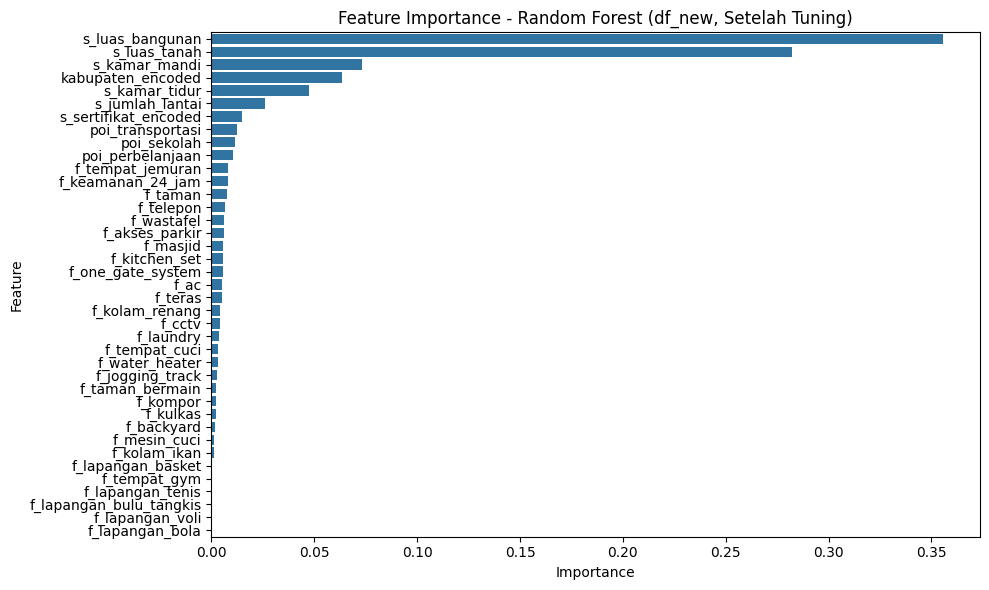


10 Fitur Teratas berdasarkan Random Forest Importance:


['s_luas_bangunan',
 's_luas_tanah',
 's_kamar_mandi',
 'kabupaten_encoded',
 's_kamar_tidur',
 's_jumlah_lantai',
 's_sertifikat_encoded',
 'poi_transportasi',
 'poi_sekolah',
 'poi_perbelanjaan']

In [ ]:
# Mengambil fitur penting dari model Random Forest terbaik (df_new)
# model_rf adalah model Random Forest yang dilatih pada data X_train (df_new) sebelumnya
# Dapatkan feature importances dari model
# Menggunakan model hasil tuning: model_rf_tuned
feature_importances = model_rf_tuned.feature_importances_

# Buat Series dari feature importances, dengan index adalah nama kolom dari X_train
# Pastikan urutan importances sesuai dengan urutan kolom di X_train
importance_series = pd.Series(feature_importances, index=X_train.columns)

# Urutkan fitur berdasarkan nilai importance secara menurun
sorted_importance = importance_series.sort_values(ascending=False)

# Tampilkan fitur dan nilainya
print("\nFeature Importance dari Random Forest (df_new, Setelah Tuning):")
print(sorted_importance)

# Visualisasi feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance.values, y=sorted_importance.index)
plt.title('Feature Importance - Random Forest (df_new, Setelah Tuning)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- Melakukan Feature Selection berdasarkan threshold ---
# Anda bisa memilih jumlah fitur teratas atau menetapkan threshold
# Contoh: Pilih 10 fitur teratas
num_top_features = 10
top_features = sorted_importance.head(num_top_features).index.tolist()

print(f"\n{num_top_features} Fitur Teratas berdasarkan Random Forest Importance:")
top_features

10 fitur terbaik

In [ ]:
# 'top_features' sudah didapatkan dari analisis feature importance sebelumnya
# Pastikan variabel 'top_features' sudah terdefinisi dan berisi daftar nama kolom fitur terbaik

# Pilih hanya kolom fitur terbaik dari X_train
X_train_selected = X_train[top_features]

# Pilih hanya kolom fitur terbaik dari X_test
X_test_selected = X_test[top_features]


best_params_rf = {
    'bootstrap': False,
    'max_depth': 28,
    'max_features': 0.5, # Catatan: max_features 0.5 relatif terhadap jumlah fitur BARU (10)
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 1704
}

# Inisialisasi model Random Forest Regressor baru dengan parameter terbaik
# Menggunakan model_rf_selected untuk membedakan dari model sebelumnya
model_rf_selected = RandomForestRegressor(random_state=42, **best_params_rf)

# Melatih model menggunakan data latih dengan fitur yang sudah dipilih
model_rf_selected.fit(X_train_selected, y_train)

# Langkah 3: Mengevaluasi model dengan 10 fitur terbaik pada data uji

# Melakukan prediksi pada data uji dengan fitur yang sudah dipilih
y_pred_rf_selected = model_rf_selected.predict(X_test_selected)

# # Evaluasi Model Random Forest (dengan fitur terpilih)

# Gunakan kembali fungsi mean_absolute_percentage_error yang sudah didefinisikan
# Pastikan fungsi ini tersedia di lingkungan Anda
# def mean_absolute_percentage_error(y_true, y_pred): ... (kode fungsi)


# Menghitung metrik evaluasi
mae_rf_selected = mean_absolute_error(y_test, y_pred_rf_selected)
mse_rf_selected = mean_squared_error(y_test, y_pred_rf_selected)
rmse_rf_selected = np.sqrt(mse_rf_selected)
r2_rf_selected = r2_score(y_test, y_pred_rf_selected)
mape_rf_selected = mean_absolute_percentage_error(y_test, y_pred_rf_selected)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model Random Forest (dengan 10 fitur terbaik) pada Data Uji:")
print(f"Mean Absolute Error (MAE): {mae_rf_selected:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf_selected:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_selected:.2f}")
print(f"R-squared (R2): {r2_rf_selected:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf_selected:.2f}%")



Evaluasi Model Random Forest (dengan 10 fitur terbaik) pada Data Uji:
Mean Absolute Error (MAE): 320638680.44
Mean Squared Error (MSE): 236363402272989600.00
Root Mean Squared Error (RMSE): 486172194.06
R-squared (R2): 0.71
Mean Absolute Percentage Error (MAPE): 15.60%


6 fitur terbaik

In [ ]:
num_top_features = 6
top_features = sorted_importance.head(num_top_features).index.tolist()


# Pilih hanya kolom fitur terbaik dari X_train, simpan di X_train_selected2
X_train_selected2 = X_train[top_features]

# Pilih hanya kolom fitur terbaik dari X_test, simpan di X_test_selected2
X_test_selected2 = X_test[top_features]

# Gunakan parameter terbaik yang sudah Anda temukan sebelumnya
best_params_rf = {
    'bootstrap': False,
    'max_depth': 28,
    'max_features': 0.5, # Catatan: max_features 0.5 relatif terhadap jumlah fitur BARU (6)
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Inisialisasi model Random Forest Regressor baru dengan parameter terbaik
# Menggunakan model_rf_selected2
model_rf_selected2 = RandomForestRegressor(random_state=42, **best_params_rf)

# Melatih model menggunakan data latih dengan fitur yang sudah dipilih (X_train_selected2)
model_rf_selected2.fit(X_train_selected2, y_train)

# Langkah 3: Mengevaluasi model dengan 6 fitur terbaik pada data uji

# Melakukan prediksi pada data uji dengan fitur yang sudah dipilih (X_test_selected2)
y_pred_rf_selected2 = model_rf_selected2.predict(X_test_selected2)

# # Evaluasi Model Random Forest (dengan 6 fitur terpilih)

# Gunakan kembali fungsi mean_absolute_percentage_error yang sudah didefinisikan

# Menghitung metrik evaluasi, simpan di variabel dengan suffix selected2
mae_rf_selected2 = mean_absolute_error(y_test, y_pred_rf_selected2)
mse_rf_selected2 = mean_squared_error(y_test, y_pred_rf_selected2)
rmse_rf_selected2 = np.sqrt(mse_rf_selected2)
r2_rf_selected2 = r2_score(y_test, y_pred_rf_selected2)
mape_rf_selected2 = mean_absolute_percentage_error(y_test, y_pred_rf_selected2)

# Menampilkan hasil evaluasi
print("\nEvaluasi Model Random Forest (dengan 6 fitur terbaik) pada Data Uji:")
print(f"Mean Absolute Error (MAE): {mae_rf_selected2:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf_selected2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_selected2:.2f}")
print(f"R-squared (R2): {r2_rf_selected2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf_selected2:.2f}%")


Evaluasi Model Random Forest (dengan 6 fitur terbaik) pada Data Uji:
Mean Absolute Error (MAE): 334688657.40
Mean Squared Error (MSE): 260753068038325824.00
Root Mean Squared Error (RMSE): 510639861.39
R-squared (R2): 0.68
Mean Absolute Percentage Error (MAPE): 16.35%


# Evaluasi

In [30]:
# Hasil Random Forest Tuned (df_new)
mae_tuned_rf = 332753756.71
mse_tuned_rf = 232456813719354784.00
rmse_tuned_rf = 482137753.88
r2_tuned_rf = 0.72
mape_tuned_rf = 16.27

# Hasil LightGBM Tuned (df_new)
mae_tuned_lgbm = 341784485.78
mse_tuned_lgbm = 228333511854738592.00
rmse_tuned_lgbm = 477842559.69
r2_tuned_lgbm = 0.72
mape_tuned_lgbm = 16.67

# Hasil Random Forest Tuned (df_new2)
mae_tuned_rf2 = 337560411.23
mse_tuned_rf2 = 250825742621526528.00
rmse_tuned_rf2 = 500825061.89
r2_tuned_rf2 = 0.69
mape_tuned_rf2 = 16.49

# Hasil LightGBM Tuned (df_new2)
mae_tuned_lgbm2 = 349262781.49
mse_tuned_lgbm2 = 246357945995794144.00
rmse_tuned_lgbm2 = 496344583.93
r2_tuned_lgbm2 = 0.70
mape_tuned_lgbm2 = 17.20

# --- Kumpulkan semua hasil evaluasi, TERMASUK hasil tuning ---
# Gunakan kembali variabel hasil model awal (rf, gb, xgb, cb, lgbm, rf2, gb2, xgb2, cb2, lgb2)
# yang seharusnya sudah ada di memori dari eksekusi sel-sel sebelumnya.
# Jika belum ada, Anda perlu menjalankan kembali sel-sel yang menghitungnya
# atau memuatnya jika sudah disimpan.

results_with_mape_and_tuning = {
    'Model': [
        'Random Forest (semua fasilitas)',
        'Gradient Boosting (semua fasilitas)',
        'XGBoost (semua fasilitas)',
        'CatBoost (semua fasilitas)',
        'LightGBM (semua fasilitas)',
        'Random Forest (fasilitas tertentu)',
        'Gradient Boosting (fasilitas tertentu)',
        'XGBoost (fasilitas tertentu)',
        'CatBoost (fasilitas tertentu)',
        'LightGBM (fasilitas tertentu)',
        'Random Forest Tuned (semua fasilitas)', # <-- Tambahan hasil tuning
        'LightGBM Tuned (semua fasilitas)',      # <-- Tambahan hasil tuning
        'Random Forest Tuned (fasilitas tertentu)',# <-- Tambahan hasil tuning
        'LightGBM Tuned (fasilitas tertentu)'     # <-- Tambahan hasil tuning
    ],
    'MAE': [
        mae_rf, mae_gb, mae_xgb, mae_cb, mae_lgbm,
        mae_rf2, mae_gb2, mae_xgb2, mae_cb2, mae_lgb2,
        mae_tuned_rf, mae_tuned_lgbm, mae_tuned_rf2, mae_tuned_lgbm2 # <-- Masukkan nilainya
    ],
    'MSE': [
        mse_rf, mse_gb, mse_xgb, mse_cb, mse_lgbm,
        mse_rf2, mse_gb2, mse_xgb2, mse_cb2, mse_lgb2,
        mse_tuned_rf, mse_tuned_lgbm, mse_tuned_rf2, mse_tuned_lgbm2 # <-- Masukkan nilainya
    ],
    'RMSE': [
        rmse_rf, rmse_gb, rmse_xgb, rmse_cb, rmse_lgbm,
        rmse_rf2, rmse_gb2, rmse_xgb2, rmse_cb2, rmse_lgb2,
        rmse_tuned_rf, rmse_tuned_lgbm, rmse_tuned_rf2, rmse_tuned_lgbm2 # <-- Masukkan nilainya
    ],
    'R2': [
        r2_rf, r2_gb, r2_xgb, r2_cb, r2_lgbm,
        r2_rf2, r2_gb2, r2_xgb2, r2_cb2, r2_lgb2,
        r2_tuned_rf, r2_tuned_lgbm, r2_tuned_rf2, r2_tuned_lgbm2 # <-- Masukkan nilainya
    ],
    'MAPE (%)': [
        mape_rf, mape_gb, mape_xgb, mape_cb, mape_lgbm,
        mape_rf2, mape_gb2, mape_xgb2, mape_cb2, mape_lgb2,
        mape_tuned_rf, mape_tuned_lgbm, mape_tuned_rf2, mape_tuned_lgbm2 # <-- Masukkan nilainya
    ]
}

# Buat DataFrame dari dictionary hasil yang diperbarui
df_results_with_mape_and_tuning = pd.DataFrame(results_with_mape_and_tuning)

# Tampilkan tabel hasil evaluasi yang baru
print("\nTabel Kumpulan Evaluasi Model Regresi (Termasuk Hasil Tuning)")
# Atur format tampilan untuk kolom angka
# pd.options.display.float_format = '{:,.2f}'.format # Jika ingin format ribuan
pd.options.display.float_format = '{:.2f}'.format # Hanya 2 angka desimal

display(df_results_with_mape_and_tuning)


Tabel Kumpulan Evaluasi Model Regresi (Termasuk Hasil Tuning)


,Model,MAE,MSE,RMSE,R2,MAPE (%)
0,Random Forest (semua fasilitas),340591673.60,231428187506545056.00,481069836.41,0.72,16.47
1,Gradient Boosting (semua fasilitas),418724819.92,290508317696587712.00,538988235.21,0.65,20.61
2,XGBoost (semua fasilitas),396971438.49,266992941617665280.00,516713597.28,0.68,19.35
3,CatBoost (semua fasilitas),409204661.25,280135199769879616.00,529277998.57,0.66,20.04
4,LightGBM (semua fasilitas),389476379.68,258408876860365696.00,508339332.40,0.69,18.97
5,Random Forest (fasilitas tertentu),339994351.55,238970969089081728.00,488846570.09,0.71,16.49
6,Gradient Boosting (fasilitas tertentu),421427023.73,293391967803029952.00,541656688.14,0.64,20.75
7,XGBoost (fasilitas tertentu),405544248.31,277747114339317472.00,527017186.00,0.66,19.77
8,CatBoost (fasilitas tertentu),417138162.66,288506045478334464.00,537127587.71,0.65,20.48
9,LightGBM (fasilitas tertentu),395831028.18,268234832053471520.00,517913923.40,0.67,19.45


# Simpan Model

In [29]:
# Tentukan nama file untuk menyimpan model, encoder dan scaler
model_filename = 'model.joblib'
encoder_filename = 'label_encoder.joblib'
scaler_filename = 'standard_scaler.joblib'

# Simpan model ke file
joblib.dump(model_rf, model_filename)

# Simpan objek scaler (gunakan scaler atau scaler2 sesuai model terbaik Anda)
joblib.dump(scaler, scaler_filename)

print(f"Model 'model_rf' telah disimpan ke '{model_filename}'")
print(f"LabelEncoder telah disimpan ke '{encoder_filename}'")
print(f"StandardScaler telah disimpan ke '{scaler_filename}'")

Model 'model_rf' telah disimpan ke 'model.joblib'
LabelEncoder telah disimpan ke 'label_encoder.joblib'
StandardScaler telah disimpan ke 'standard_scaler.joblib'
